In [1]:
%matplotlib inline


# Nuth and Kääb coregistration

Nuth and Kääb ([2011](https:https://doi.org/10.5194/tc-5-271-2011)) coregistration allows for horizontal and vertical shifts to be estimated and corrected for.
In ``xdem``, this approach is implemented through the :class:`xdem.coreg.NuthKaab` class.

For more information about the approach, see `coregistration_nuthkaab`.


In [2]:
import geoutils as gu
import numpy as np
import xdem

**Example files**



In [3]:
reference_dem = xdem.DEM(xdem.examples.get_path("longyearbyen_ref_dem"))
dem_to_be_aligned = xdem.DEM(xdem.examples.get_path("longyearbyen_tba_dem"))
glacier_outlines = gu.Vector(xdem.examples.get_path("longyearbyen_glacier_outlines"))

# Create a stable ground mask (not glacierized) to mark "inlier data"
inlier_mask = ~glacier_outlines.create_mask(reference_dem)

The DEM to be aligned (a 1990 photogrammetry-derived DEM) has some vertical and horizontal biases that we want to avoid.
These can be visualized by plotting a change map:



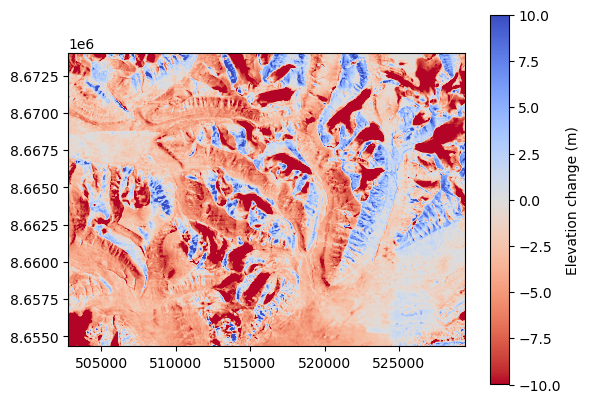

In [4]:
diff_before = reference_dem - dem_to_be_aligned
diff_before.show(cmap="coolwarm_r", vmin=-10, vmax=10, cb_title="Elevation change (m)")

Horizontal and vertical shifts can be estimated using :class:`xdem.coreg.NuthKaab`.
First, the shifts are estimated, and then they can be applied to the data:



In [6]:
nuth_kaab = xdem.coreg.NuthKaab()

nuth_kaab.fit(reference_dem, dem_to_be_aligned, inlier_mask, verbose=True)

aligned_dem = nuth_kaab.apply(dem_to_be_aligned)

Running Nuth and Kääb (2011) coregistration
   Calculate slope and aspect
   Statistics on initial dh:
      Median = -2.33 - NMAD = 3.42
   Iteratively estimating horizontal shit:


   Progress:  10%|███                            | 1/10 [00:00<00:02,  3.63it/s]

      #1 - Offset in pixels : (-0.44, -0.15)
      Median = -1.98 - NMAD = 2.51  ==>  Gain = -26.57%


   Progress:  20%|██████▏                        | 2/10 [00:00<00:02,  3.59it/s]

      #2 - Offset in pixels : (-0.02, 0.01)
      Median = -1.98 - NMAD = 2.50  ==>  Gain = -0.43%


   Progress:  20%|██████▏                        | 2/10 [00:00<00:03,  2.39it/s]


      #3 - Offset in pixels : (-0.00, 0.00)
      Median = -1.98 - NMAD = 2.50  ==>  Gain = 0.00%
   Last offset was below the residual offset threshold of 0.05 -> stopping

   Final offset in pixels (east, north) : (-0.463330, -0.134549)
   Statistics on coregistered dh:
      Median = -1.98 - NMAD = 2.50


Then, the new difference can be plotted to validate that it improved.



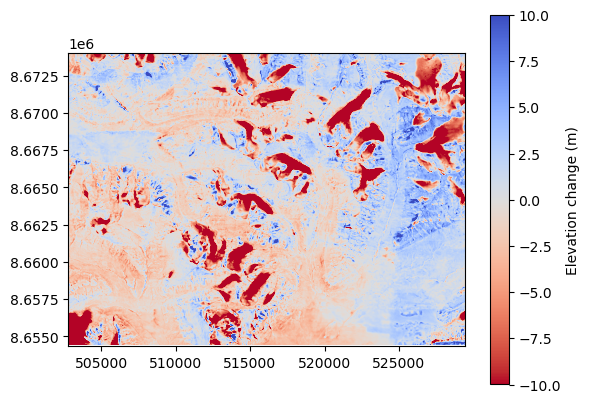

In [7]:
diff_after = reference_dem - aligned_dem
diff_after.show(cmap="coolwarm_r", vmin=-10, vmax=10, cb_title="Elevation change (m)")

We compare the median and NMAD to validate numerically that there was an improvement (see `robuststats_meanstd`):



In [8]:
inliers_before = diff_before.data[inlier_mask].compressed()
med_before, nmad_before = np.median(inliers_before), xdem.spatialstats.nmad(inliers_before)

inliers_after = diff_after.data[inlier_mask].compressed()
med_after, nmad_after = np.nanmedian(inliers_after), xdem.spatialstats.nmad(inliers_after)

print(f"Error before: median = {med_before:.2f} - NMAD = {nmad_before:.2f} m")
print(f"Error after: median = {med_after:.2f} - NMAD = {nmad_after:.2f} m")

Error before: median = -2.33 - NMAD = 3.42 m
Error after: median = -0.01 - NMAD = 2.51 m


In the plot above, one may notice a positive (blue) tendency toward the east.
The 1990 DEM is a mosaic, and likely has a "seam" near there.
`sphx_glr_advanced_examples_plot_blockwise_coreg.py` tackles this issue, using a nonlinear coregistration approach.

